Scanning for data in: /Users/ktgiahieu/Documents/review-assistant/AnalyzeMetareviews/metareviews
--- Loaded Data Structure ---
-----------------------------

Processing aggregated model data...
 - Analyzing model: Llama-4-Maverick-17B-128E-Instruct-FP8
   Results: {'micro_mention_ratio': 0.30054530201342283, 'macro_mention_ratio': np.float64(0.3181356188278599), 'micro_reasoning_ratio': 0.13136185682326623, 'macro_reasoning_ratio': np.float64(0.13867313582485202)}
 - Analyzing model: gpt-4o-2024-11-20
   Results: {'micro_mention_ratio': 0.3575349128048357, 'macro_mention_ratio': np.float64(0.3712113761167117), 'micro_reasoning_ratio': 0.25693045230320294, 'macro_reasoning_ratio': np.float64(0.2692152965603912)}
 - Analyzing model: o1-2024-12-17
   Results: {'micro_mention_ratio': 0.3168391994478951, 'macro_mention_ratio': np.float64(0.33252309171677774), 'micro_reasoning_ratio': 0.21959972394755004, 'macro_reasoning_ratio': np.float64(0.2328075058237174)}
 - Analyzing model: o3-2025-04

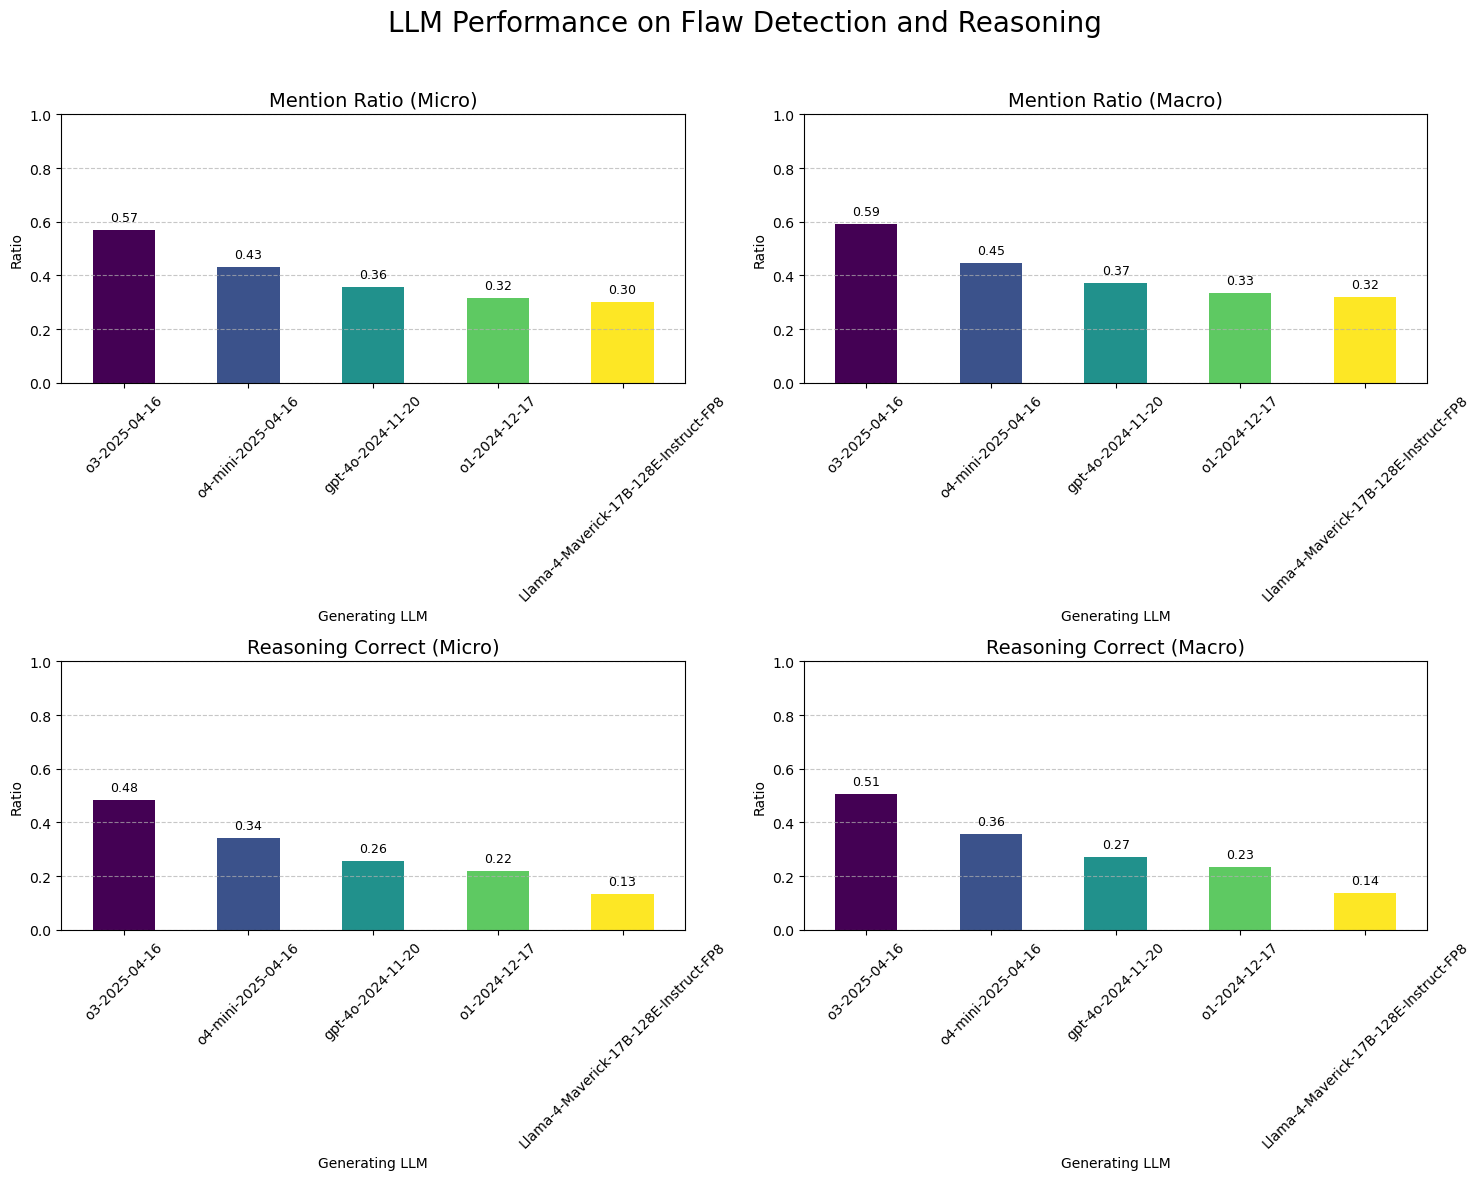

Plot displayed.


In [12]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pprint

def load_data_from_file(filepath):
    """Loads JSON data from a single file."""
    try:
        with open(filepath, 'r') as f:
            return json.load(f)
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Error reading or parsing {filepath}: {e}")
        return None

def load_all_data_structured(base_path):
    """
    Scans the directory structure to find and load all JSON files,
    categorizing them by the generating LLM (o3, o4-mini, etc.), venue, 
    and acceptance status.
    """
    structured_data = []
    base_path_abs = os.path.abspath(base_path)
    print(f"Scanning for data in: {base_path_abs}")
    
    # The first level of directories are the models themselves
    if not os.path.exists(base_path):
        print(f"Warning: Base directory not found at {base_path_abs}")
        return []

    for model_name in os.listdir(base_path):
        model_path = os.path.join(base_path, model_name)
        if os.path.isdir(model_path):
            # Now walk through each model's directory
            for root, dirs, files in os.walk(model_path):
                for file in files:
                    if file.endswith(".json"):
                        filepath = os.path.join(root, file)
                        
                        # Extract venue and status from the path
                        norm_root = os.path.normpath(root)
                        path_parts = norm_root.split(os.sep)
                        
                        # Find the model directory index to anchor the logic
                        try:
                            model_index = path_parts.index(model_name)
                            # Expected structure: .../{model_name}/{venue}/{status}
                            if len(path_parts) > model_index + 2:
                                venue = path_parts[model_index + 1]
                                status = path_parts[model_index + 2]
                            else:
                                venue, status = 'unknown', 'unknown'
                        except ValueError:
                            venue, status = 'unknown', 'unknown'

                        data = load_data_from_file(filepath)
                        if data:
                            record = {
                                'model': model_name,
                                'venue': venue,
                                'status': status,
                                'data': data
                            }
                            structured_data.append(record)

    if not structured_data:
        print("Warning: No data files were found. Check the BASE_DIRECTORY path and structure.")
    return structured_data

def calculate_metrics(model_data):
    """
    Calculates micro and macro averaged ratios for flaw detection
    and reasoning correctness.
    """
    if not model_data:
        return {
            'micro_mention_ratio': 0,
            'macro_mention_ratio': 0,
            'micro_reasoning_ratio': 0,
            'macro_reasoning_ratio': 0
        }

    # For Micro-Averaging
    total_flaws = 0
    total_mentions = 0
    total_correct_reasoning = 0

    # For Macro-Averaging
    paper_mention_ratios = []
    paper_reasoning_ratios = []

    for paper_id, flaws in model_data.items():
        if not isinstance(flaws, list) or not flaws:
            continue

        num_flaws_in_paper = len(flaws)
        mentions_in_paper = 0
        correct_reasoning_in_paper = 0

        total_flaws += num_flaws_in_paper

        for flaw in flaws:
            if isinstance(flaw, dict) and flaw.get('is_flaw_mentioned'):
                mentions_in_paper += 1
            if isinstance(flaw, dict) and flaw.get('is_reasoning_correct'):
                correct_reasoning_in_paper += 1

        # Accumulate for micro average
        total_mentions += mentions_in_paper
        total_correct_reasoning += correct_reasoning_in_paper

        # Calculate and store per-paper ratios for macro average
        if num_flaws_in_paper > 0:
            paper_mention_ratios.append(mentions_in_paper / num_flaws_in_paper)
            paper_reasoning_ratios.append(correct_reasoning_in_paper / num_flaws_in_paper)

    # Calculate final averages
    micro_mention_ratio = total_mentions / total_flaws if total_flaws > 0 else 0
    micro_reasoning_ratio = total_correct_reasoning / total_flaws if total_flaws > 0 else 0

    macro_mention_ratio = np.mean(paper_mention_ratios) if paper_mention_ratios else 0
    macro_reasoning_ratio = np.mean(paper_reasoning_ratios) if paper_reasoning_ratios else 0

    return {
        'micro_mention_ratio': micro_mention_ratio,
        'macro_mention_ratio': macro_mention_ratio,
        'micro_reasoning_ratio': micro_reasoning_ratio,
        'macro_reasoning_ratio': macro_reasoning_ratio
    }
def plot_results(results_df):
    """
    Plots the aggregated performance metrics for each model,
    creating a separate plot for each metric.
    """
    # Create a 2x2 subplot grid
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    fig.suptitle('LLM Performance on Flaw Detection and Reasoning', fontsize=20)
    
    metrics_to_plot = results_df.columns
    colors = plt.cm.viridis(np.linspace(0, 1, len(results_df.index)))

    # Flatten axes array for easy iteration
    ax_flat = axes.flatten()

    for i, metric in enumerate(metrics_to_plot):
        ax = ax_flat[i]
        # Plot data for the current metric
        results_df[metric].sort_values(ascending=False).plot(
            kind='bar', 
            ax=ax,
            color=colors
        )

        ax.set_title(metric, fontsize=14)
        ax.set_ylabel('Ratio', fontsize=10)
        ax.set_xlabel('Generating LLM', fontsize=10)
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.set_ylim(0, 1)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Add value labels on top of each bar
        for p in ax.patches:
            ax.annotate(f"{p.get_height():.2f}",
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 9),
                        textcoords='offset points',
                        fontsize=9)
    
    # Adjust layout to prevent titles and labels from overlapping
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


if __name__ == '__main__':
    # --- Configuration ---
    # This should be the root directory containing your 'metareviews' folder
    BASE_DIRECTORY = './metareviews'

    # --- Main Execution ---
    # 1. Load all data and its context from the file system
    all_structured_data = load_all_data_structured(BASE_DIRECTORY)
    
    print("--- Loaded Data Structure ---")
    print("-----------------------------\n")

    # 2. Aggregate all papers for each model
    model_aggregated_data = {}
    for record in all_structured_data:
        model_name = record['model']
        if model_name not in model_aggregated_data:
            model_aggregated_data[model_name] = {}
        # Combine all papers for a model into one large dictionary
        model_aggregated_data[model_name].update(record['data'])

    # 3. Calculate metrics for each model based on the aggregated data
    all_results = {}
    print("Processing aggregated model data...")
    # Sort models alphabetically for consistent output
    for model_name in sorted(model_aggregated_data.keys()):
        combined_data = model_aggregated_data[model_name]
        print(f" - Analyzing model: {model_name}")
        
        metrics = calculate_metrics(combined_data)
        all_results[model_name] = metrics
        print(f"   Results: {metrics}")

    # 4. Convert results to a pandas DataFrame for easier plotting
    results_df = pd.DataFrame(all_results).T # Transpose to have models as rows
    results_df.rename(columns={
        'micro_mention_ratio': 'Mention Ratio (Micro)',
        'macro_mention_ratio': 'Mention Ratio (Macro)',
        'micro_reasoning_ratio': 'Reasoning Correct (Micro)',
        'macro_reasoning_ratio': 'Reasoning Correct (Macro)'
    }, inplace=True)

    print("\n--- Final Aggregated Results ---")
    print(results_df)
    print("--------------------------------\n")

    # 5. Plot the results
    if not results_df.empty:
        print("Generating plot...")
        plot_results(results_df)
        print("Plot displayed.")
    else:
        print("No results to plot. Ensure your BASE_DIRECTORY is correct and contains data.")
